In [95]:
from qiskit_ibm_runtime import QiskitRuntimeService
token = "REPLACE WITH IBM TOKEN"
service = QiskitRuntimeService(
    token=token,
    channel="ibm_quantum"
)
backend = service.backend("ibm_rensselaer")
import matplotlib.pyplot as plt

In [96]:
import numpy as np
dt = backend.dt
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
lcm = np.lcm(acquire_alignment, pulse_alignment)
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)
def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [97]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.compiler import schedule
qubit = 3
target = backend.target
inst = target["x"][(qubit, )]
# inst.calibration.instructions[0][1].pulse.beta

# Drive pulse parameters (us = microseconds)
us = 1.0e-6  # Microseconds
num_rabi_points = 100
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8  

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = 272
    drive_sigma = 68
    drive_chan = pulse.drive_channel(qubit)
    # pulse.set_frequency(, drive_chan)
    pulse.play(pulse.Drag(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              beta=inst.calibration.instructions[0][1].pulse.beta,  
                              name='Rabi Pulse'), drive_chan)


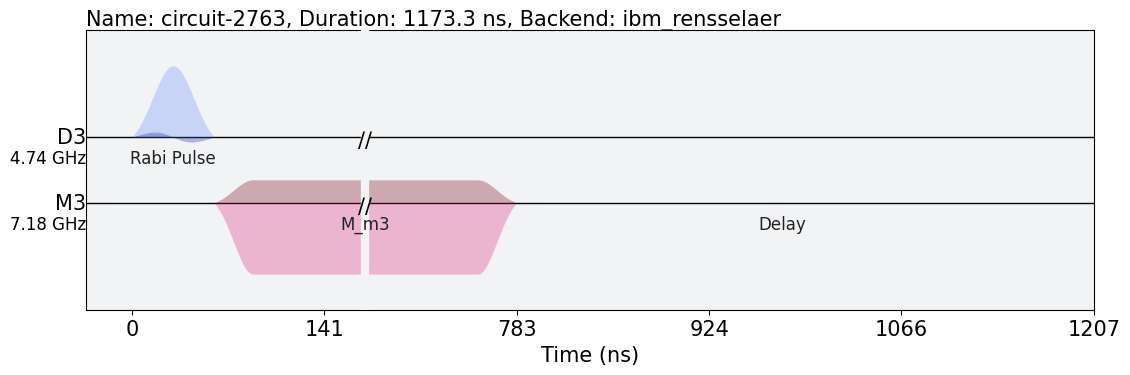

In [98]:
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(backend.num_qubits, 1)

qc_rabi.append(rabi_gate, [qubit])
qc_rabi.measure(qubit, 0)
qc_rabi.add_calibration(rabi_gate, (qubit,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]
rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [99]:
from qiskit_ibm_runtime import Sampler
sampler = Sampler(mode=backend)
job = sampler.run(exp_rabi_circs, shots=1024)

In [100]:
res_lst = []
for res in job.result():
    res_lst.append(res.data.c.get_counts()['0'] / 1024)

In [101]:
target = backend.target
inst = target["x"][(102, )]
inst.calibration

Schedule((0, Play(Drag(duration=272, sigma=68, beta=-0.0647121788697894, amp=0.2138477550950565, angle=0.0, name='Xp_d102'), DriveChannel(102), name='Xp_d102')), name="x")

In [102]:
from scipy.optimize import curve_fit
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

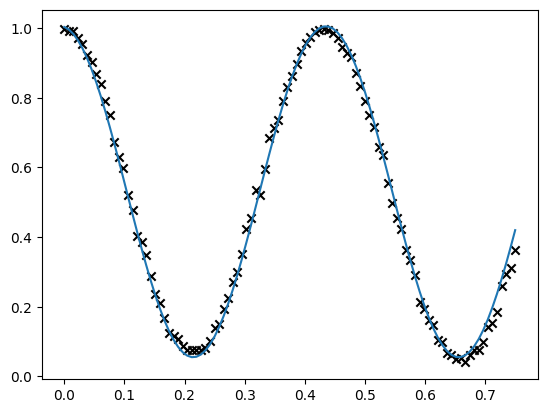

In [103]:
fit_params, y_fit = fit_function(drive_amps,
                                 res_lst, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.4, 0])
plt.scatter(drive_amps, res_lst, marker='x', color='black')
plt.plot(drive_amps, y_fit)

In [104]:
drive_period = fit_params[2]
new_amp = drive_period / 2

In [105]:
beta_min = -5
beta_max = 5
num_betas = 100
betas = np.linspace(beta_min, beta_max, num_betas)
drive_beta = Parameter('drive_beta')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched2:
    drive_duration = 272
    drive_sigma = 68
    drive_chan = pulse.drive_channel(qubit)
    # pulse.set_frequency(, drive_chan)
    pulse.play(pulse.Drag(duration=drive_duration,
                              amp=drive_period/2,
                              sigma=drive_sigma,
                              beta=drive_beta,  
                              name='Rabi Pulse'), drive_chan)

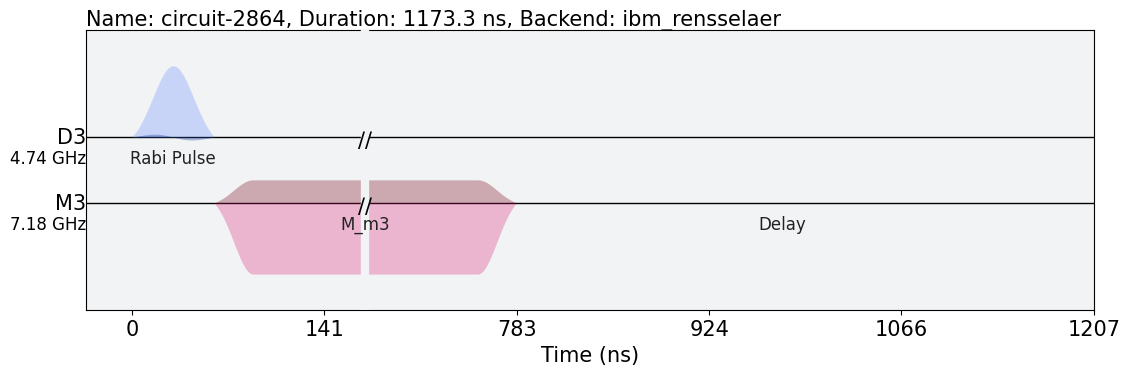

In [106]:
rabi_gate = Gate("rabi", 1, [drive_beta])

qc_rabi = QuantumCircuit(backend.num_qubits, 1)

qc_rabi.append(rabi_gate, [qubit])
qc_rabi.measure(qubit, 0)
qc_rabi.add_calibration(rabi_gate, (qubit,), rabi_sched2, [drive_beta])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_beta: a}, inplace=False) for a in betas]
rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [107]:
job = sampler.run(exp_rabi_circs, shots=1024)

In [108]:
job.result()
res_lst = []
for res in job.result():
    res_lst.append(res.data.c.get_counts()['1'] / 1024)

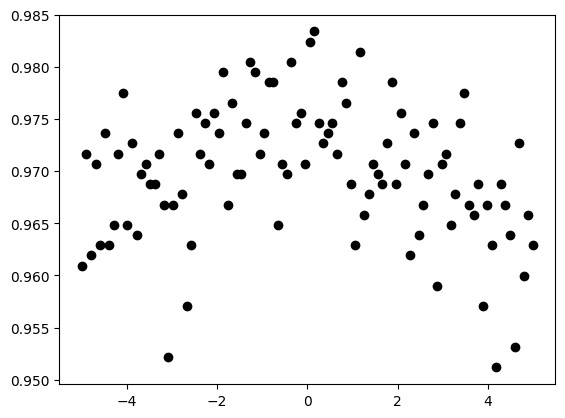

In [109]:
plt.scatter(betas, res_lst, color='black')  # Plot the datapoints

In [110]:
new_beta = betas[np.argmax(res_lst)]

In [111]:
from qiskit_experiments.library import InterleavedRB
from qiskit.circuit.library import XGate
irb_exp = InterleavedRB(
    interleaved_element=XGate(),
    backend=backend,
    physical_qubits=[qubit],
    num_samples=5,
    lengths=np.arange(10, 400, 20),
)
irb_data = irb_exp.run()

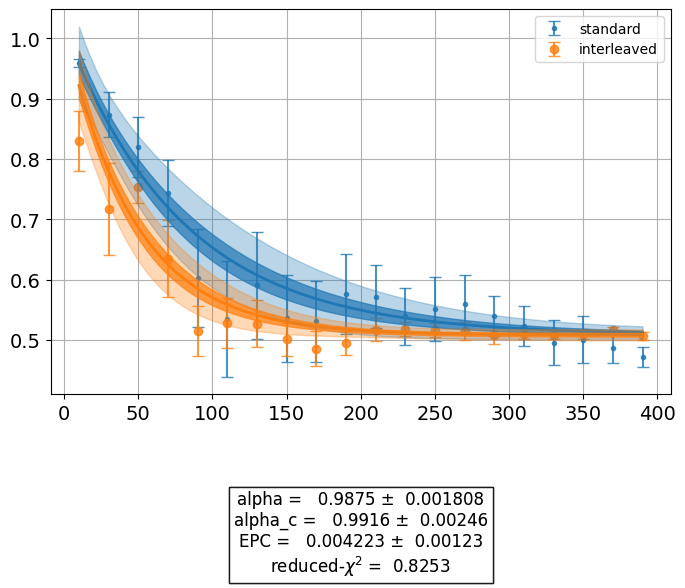

In [112]:
while True:
    if "successfully" in irb_data.analysis_status().value:
        a = irb_data.figure(0)
        break
a

In [113]:
from qiskit import pulse
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi 3') as rabi_3:
    drive_duration = 272
    drive_sigma = 68
    drive_chan = pulse.drive_channel(3)
    # pulse.set_frequency(, drive_chan)
    pulse.play(pulse.Drag(duration=drive_duration,
                              amp=new_amp,
                              sigma=68,
                              beta=new_beta,  
                              name='Rabi 3'), drive_chan)

In [114]:
from copy import deepcopy
# import instructionproperties
from qiskit.transpiler import InstructionProperties
backend_tmp = deepcopy(backend)
backend_tmp.target["x"][(qubit, )] = InstructionProperties(
    calibration=rabi_3
)

In [115]:
from qiskit_experiments.library import InterleavedRB
from qiskit.circuit.library import XGate
irb_exp = InterleavedRB(
    interleaved_element=XGate(),
    backend=backend,
    physical_qubits=[qubit],
    num_samples=5,
    lengths=np.arange(10, 400, 20),
)
irb_data = irb_exp.run()

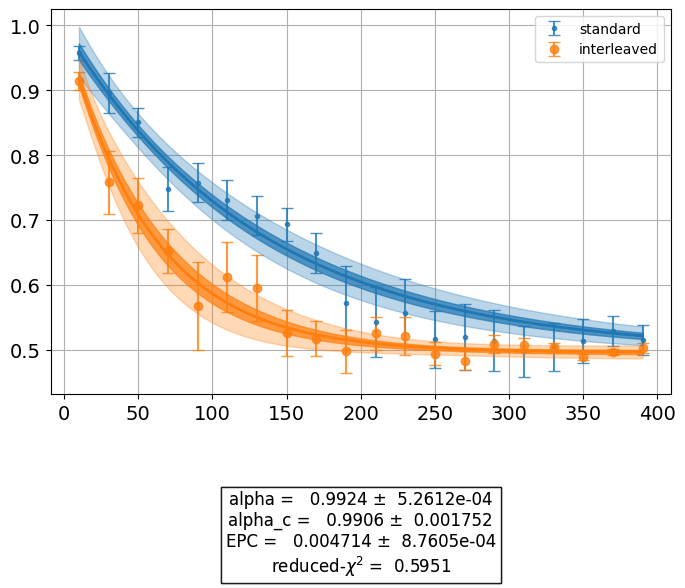

In [116]:
while True:
    if "successfully" in irb_data.analysis_status().value:
        a = irb_data.figure(0)
        break
a

In [117]:
new_amp, new_beta

(0.22081676543758424, 0.15151515151515138)